In [1]:

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Digital quantum simulation of the Ising model

The Ising model is one of the most studied statistical physics model in the context of phase transitions and out-of-equilibrium quantum systems.
Its Hamiltonian reads

$H=J\sum_{\langle i,j\rangle } Z_i Z_j - h \sum_i X_i \,$

where $Z$ and $X$ represent Pauli matrices and the first sum runs over nearest-neighbours pairs on some d-dimensional lattice. Here, we will consider only one and two spatial dimensions.
Despite its simplicity, it is a useful toy model to understand many complex phenomena and is a perfect benchmark for our ability to implement quantum simulations. 

Let us start with defining the lattice structure and the graph connectivity. It is an overkill, but it will allow us later on to generalize to a more complex scenario.

In [2]:
def nn_adj_matrix(n):
    """
    Generate the adjacency matrix for a simple 1d chain of 'n' sites.
    """
    num_nodes = n
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
 
    for i in range(n-1):
        a, b = i, i + 1  # Nodes of chain
 
        # Connect nearest neighbours on the chain
        adj_matrix[a, b] = adj_matrix[b, a] = 1
      
    return adj_matrix


def plot_nn_chain(n, side=1.0):
    """
    Plot 1d chain with nearest-neighbour coupling and lattice spacing 'side'.
    Baseline: even nodes (0,2,4,...,2n) on y=0
    Apexes: odd nodes (1,3,5,...,2n-1) above the midpoint.
    """
    # Build graph
    A = nn_adj_matrix(n)
    G = nx.from_numpy_array(A)
 
    pos = {}
 
    # Place baseline nodes
    for k in range(n):
        pos[k] = (k * side, 0.0)
 
 
    # Draw
    fig, ax = plt.subplots(figsize=(1.5 * n, 2))
    nx.draw(
        G,
        pos,
        ax=ax,
        with_labels=True,
        font_size=10,
        font_color="white",
        node_size=600,
        node_color='blue',
        edge_color="black",
        width=2,
    )
    #ax.set_aspect("equal")
    ax.margins(0.1)
    plt.show()
 
    return G, pos

#### Let us look at what we have done

A= [[0 1 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 0]
 [0 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 1 0]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 1 0]]


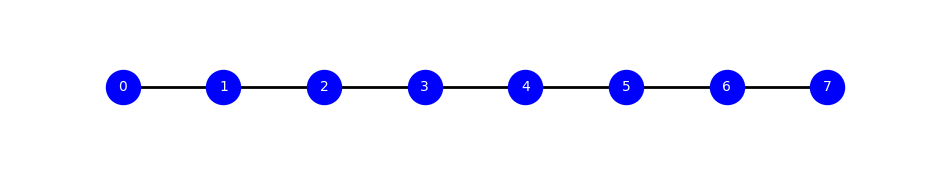

In [3]:
n_qubits = 8
A = nn_adj_matrix(n_qubits)
G = nx.from_numpy_array(A)
print('A=',A)
plot_nn_chain(n_qubits, side=1.0)
plt.show()

## Step 2: Optimize problem for quantum hardware execution

#### Generate Trotterized circuits on spin graphs

To simulate the dynamics of the  dynamics of the transverse-field Ising model (TFIM), we construct circuits that approximate the time evolution operator.
$U(t) = e^{-iHt}$, where $H=J\sum_{\langle i,j\rangle}Z_i Z_j - h \sum_i X_i$.

We use a second-order Trotter decomposition:
$
e^{-iH\Delta t } \sim e^{-iH_x\Delta t/2} e^{-iH_z\Delta t}e^{-iH_x\Delta t/2},
$

where $H_X = -h\sum_i X_i$ and $H_Z = H=J\sum_{\langle i,j\rangle}Z_i Z_j$.

- The $H_X$ is implemented with layers of $RX$ rotations
- The $H_Z$ term is implemented with layers of $RZ$ gates sandwiched between CNOTs along the edges of the interaction graph. (Check pen-and-paper that this is indeed the case!)


The angles of these gates are determined by the transverse field $h$, the coupling constant $J$,  and the time step $\Delta t$. By stacking multiple Trotter steps, we generate circuits of increasing depth that approximate the system's dynamics. 
The functions generate_tfim_circ_custom_graph and trotter_circuits construct a Trotterized quantum circuit from an arbitrary spin interaction graph.

#### TASK 1:
Write the elementary building block for simulating the Ising $ZZ$ interaction on just two qubits.

<details>
<summary><b>Click to reveal solution</b></summary>

```python
def my_rzz(qc, qlist,theta_zz):
    qc.cx(qlist[0],qlist[1])
    qc.rz(theta_zz,qlist[1])
    qc.cx(qlist[0],qlist[1])
    return qc


```
</details>

##### Depth optimization via edge grouping 

On real quantum hardware, two-qubit gates (e.g., CNOTs) are expensive, so we want to minimize circuit depth by applying as many CNOTs as possible in parallel.
To do this, we partition the edges of the interaction graph into groups of disjoint edges, i.e. edges that do not share any node.  
All edges within the same group can be executed in the same circuit layer.

For a 1D nearest-neighbour chain with $n$ qubits (nodes labeled $(0,1,\dots,n-1)$), we write a function that returns a list of “color groups” (layers), where each layer is a list of non-overlapping pairs:
$[[(a,b),(c,d),...],[(b,c),(d,e),...],...]$

In [4]:
def pair_selection_1d(n):
    color_groups=[[],[]]
    #even-odd
    for j in range(int(n/2)):
        color_groups[0].append((2*j,2*j+1))
    #odd-even
        if j == int(n/2)-1: continue
        color_groups[1].append((2*j+1,2*j+2))
    
    return color_groups

n=8
pairs=pair_selection_1d(n)
print(pairs)

[[(0, 1), (2, 3), (4, 5), (6, 7)], [(1, 2), (3, 4), (5, 6)]]


#### TASK 2: Implement a single Trotter step for the TFIM

We now want to build the elementary building block of the digital simulation: one Trotter step for the transverse-field Ising model (TFIM)

$H = J\sum_{\langle i,j\rangle} Z_i Z_j - h\sum_i X_i,$

using the evolution for a small time step \(\Delta t\) with a **second-order Trotter–Suzuki** formula:

$e^{-iH\Delta t}\approx e^{-iH_X\Delta t/2}\; e^{-iH_Z\Delta t}\; e^{-iH_X\Delta t/2},$

Write a function that generates a **single Trotter step circuit** on $(n_q)$ qubits:

1. **First “half-step” $X$ layer**  
   Apply an $R_X(\theta_X)$ rotation **to every qubit** .

2. **$ZZ$ interaction layer(s)**  
   For each coupling $\langle i,j\rangle$ in the Ising graph, apply the two-qubit evolution using the **two-qubit building block** you wrote in **TASK 1**.

   To reduce circuit depth, do not apply edges one by one: instead, use the **edge groups** (the list of layers of disjoint edges) using the **pair_selection_1d** function.

3. **Second “half-step” $X$ layer**  
   Apply again an $R_X(\theta_X)$ rotation **to every qubit**.



<details>
<summary><b>Click to reveal solution</b></summary>

```python
def generate_tfim_single_trotter_step(
    nq, theta_x, theta_zz, pairs_set, mirror=False
):
    """
    Generate a single second-order Trotter step for the TFIM:
    e^(b/2) e^a e^(b/2)

    nq: Number of qubits
    theta_x: Angle for RX rotations (0.5 * h * dt)
    theta_zz: Angle for RZZ interactions (- J * dt)
    pairs_set: set of non-consecutive graph edges for ZZ interactions
    mirror: Whether to reverse the edge ordering
    """
    circ = QuantumCircuit(nq)

    # First half-step X rotations: e^(b/2)
    for i in range(nq):
        circ.rx(theta_x, i)
    
    # ZZ interactions: e^a
    if mirror:
        pairs_set = [sublist[::-1] for sublist in pairs_set[::-1]]
    for edge_list in pairs_set:
        for edge in edge_list:
            circ = my_rzz(circ, edge, theta_zz)
            '''circ.cx(edge[0], edge[1])
            circ.rz(theta_zz, edge[1])
            circ.cx(edge[0], edge[1])
            '''
    # Second half-step X rotations: e^(b/2)
    for i in range(nq):
        circ.rx(theta_x, i)

    return circ

# check that it looks as it should
nq =8
theta_x =0.2
theta_zz=0.5
cirq = generate_tfim_single_trotter_step(nq, theta_x, theta_zz, pairs_set=pair_selection_1d(nq))
cirq.draw('mpl')


```
</details>

#### TASK 3: Build the full Trotterized circuit and add measurements

Concatenate different trotter step to build the entire circuit. At the end, we want to measure the qubits either in the $X$, $Y$, or $Z$ basis.

Your goal is to:

1. Prepare an initial state: consider only product states in the computational basis such as $|11110000\rangle$ and recall that Qiskit initializes all qubits in the state $|0\rangle$, therefore, to prepare a generic product state you only need to apply an $X$ gate on the qubits corresponding to the bits equal to `1`.

2. Concatenate multiple second-order Trotter steps. Your function should:

    - Compute the rotation angles from $h$, $J$, and $dt$.
    - Call your `generate_tfim_single_trotter_step(...)` function written in **TASK2** to implement a single trotter step.
    - Concatenate the Trotter steps.

3. Measure the final state in a chosen basis: $X$, $Y$, or $Z$ basis.


The input data of the `generate_tfim_circ_custom_graph` functio should be:
- the number of trotter steps
- the time step $dt$ (or the total time)
- the transverse field $h$ and the $ZZ$ coupling $J$
- the initial state 
- the coupling connectivity (use the graph G defined before)



<details>
<summary><b>Click to reveal solution</b></summary>

```python
def generate_tfim_circ_custom_graph(
    steps, h, J, dt, psi0, graph: nx.graph.Graph, meas_basis="Z", mirror=False
):
    """
    Generate a second-order Trotter circuit for the TFIM by concatenating
    single Trotter steps and appending a final measurement.

    steps: Number of Trotter steps
    h: Transverse magnetic field strength
    J: Coupling between nearest-neighbor spins
    dt: t / total_steps
    psi0: Initial state (computational basis string, e.g. '0110')
    graph: nx.graph object that encodes the lattice connectivity
    meas_basis: Measurement basis ('X', 'Y', or 'Z')
    mirror: Whether to reverse edge ordering each step
    """
    theta_x = h * dt * 0.5
    theta_zz = - J * dt
    nq = graph.number_of_nodes()
    pairs_set = pair_selection_1d(nq)

    circ = QuantumCircuit(nq, nq)

    # Initial state preparation
    for i, b in enumerate(psi0):
        if b == "1":
            circ.x(i)

    # Concatenate Trotter steps
    for step in range(steps):
        trotter_step = generate_tfim_single_trotter_step(
            nq, theta_x, theta_zz, pairs_set, mirror=mirror
        )
        circ.compose(trotter_step, inplace=True)
        circ.barrier()

    # Basis rotations before measurement
    if meas_basis == "X":
        for b in range(nq):
            circ.h(b)
    elif meas_basis == "Y":
        for b in range(nq):
            circ.sdg(b) #this is the phase gate with phi = pi/2
            circ.h(b)

    # Measurements
    circ.measure(range(nq), range(nq))

    return circ

#again, let's check that it looks correct
h=0.5
J=1
dt=0.25
steps=2
psi0=['0' for j in range(n_qubits)]

      
circ=generate_tfim_circ_custom_graph(
    steps, h, J, dt, psi0, G, meas_basis="Y", mirror=False
)
circ.draw('mpl')

```

#### Building a list of circuits for dynamical evolution

The following function generates a **list of quantum circuits** with increasing depth, corresponding to different total simulation times.
By sweeping over the number of Trotter steps, we obtain circuits representing the system at different times during the evolution.

This structure allows us to study the **real-time dynamics** of physical observables (e.g., magnetization or correlation functions), which we will analyze in the next section.

In [9]:
def trotter_circuits(G, tot_steps, J, h, dt, meas_basis, mirror=True):
    """
    Generates a sequence of Trotterized circuits, each with increasing depth.
    Given a spin interaction graph and Hamiltonian parameters, it constructs
    a list of circuits with 1 to tot_steps Trotter steps
 
    G: Graph defining spin interactions (edges = ZZ couplings)
    tot_steps: Number of Trotter steps (maximum depth)
    J: Coupling between nearest neighboring spins
    h: Transverse magnetic field strength
    dt: (t / total_steps
    meas_basis: Basis to measure all correlators in. Must be "X", "Z", or "Y"
    mirror: If True, mirror the Trotter layers
    """
    n_qubits = len(G)
    circuits = []
    psi0 = "0" * n_qubits
 
    for steps in range(1, tot_steps + 1):
        circuits.append(
            generate_tfim_circ_custom_graph(
                steps, h, J, dt, psi0, G, meas_basis, mirror
            )
        )
    return circuits

## Step 3: Measurement-based readout (shots) and observable estimation

In this step we execute the list of Trotterized circuits and collect **measurement outcomes**.  
Because measurements are **shot-based**, each circuit execution returns a set of bitstrings (e.g. `010110...`) together with the number of times each outcome occurred.

These measurement statistics are the raw data needed to estimate physically relevant quantities such as:

- the **energy** of the system, e.g. $E = \langle H_Z \rangle$
- the **magnetization**, e.g. $M_z = \sum_i \langle Z_i \rangle$


To estimate expectation values, we will first convert outcome **counts** into **probabilities**:
if an outcome $s$ appears $n_s$ times out of a total number of shots $N_{\text{shots}}$, then

$$
p(s) = \frac{n_s}{N_{\text{shots}}}.
$$



#### TASK 4: Run the circuits and normalize measurement outcomes

Write utilities that:

1. **Define a backend** (simulator for now) and execute a **list of circuits** with a chosen number of shots $N_{\text{shots}}$.
2. Collect the raw results as a **list of dictionaries** (one per circuit) of the form  
   `{"bitstring": counts, ...}`, where each bitstring labels a measurement outcome and the corresponding value is the number of times it was observed.
3. Implement a function that converts each dictionary of counts into a dictionary of **probabilities**, by dividing each count by the total number of shots.

Your final output should be a list like where each element is a dictionary `{"bitstring": probability, ...}` corresponding to a different circuit depth (i.e. a different simulation time).


In [10]:
backend_sim_exact = AerSimulator(method="automatic")
 
 
def normalize_counts(counts_list, shots):
    new_counts_list = []
    for counts in counts_list:
        a = {k: v / shots for k, v in counts.items()}
        new_counts_list.append(a)
    return new_counts_list
 
 
def run_sim(circ_list,backend_sim,shots=4096):
    res = backend_sim.run(circ_list, shots=shots)
    normed = normalize_counts(res.result().get_counts(), shots)
    return normed
 
tot_steps = 20
n_qubits = 2
A = nn_adj_matrix(n_qubits)
G = nx.from_numpy_array(A)
J=1
h=2
dt=0.2
circ = trotter_circuits(G, tot_steps, J, h, dt, "Z", True)

sim_counts = run_sim(circ,backend_sim_exact)
print(sim_counts)


[{'00': 0.927734375, '10': 0.03564453125, '01': 0.034423828125, '11': 0.002197265625}, {'00': 0.7216796875, '01': 0.12939453125, '10': 0.128662109375, '11': 0.020263671875}, {'01': 0.212646484375, '00': 0.4794921875, '11': 0.096435546875, '10': 0.21142578125}, {'10': 0.237060546875, '00': 0.27001953125, '01': 0.2314453125, '11': 0.261474609375}, {'01': 0.18505859375, '11': 0.473876953125, '00': 0.16064453125, '10': 0.180419921875}, {'01': 0.093994140625, '11': 0.685791015625, '00': 0.124267578125, '10': 0.095947265625}, {'11': 0.83203125, '00': 0.137451171875, '01': 0.017333984375, '10': 0.01318359375}, {'11': 0.85986328125, '00': 0.131591796875, '10': 0.004638671875, '01': 0.00390625}, {'01': 0.072998046875, '11': 0.739501953125, '00': 0.11865234375, '10': 0.06884765625}, {'11': 0.574951171875, '01': 0.164306640625, '10': 0.1640625, '00': 0.0966796875}, {'10': 0.22412109375, '11': 0.434814453125, '01': 0.220458984375, '00': 0.12060546875}, {'10': 0.227294921875, '11': 0.348876953125, 

<details>
<summary><b>Click to reveal solution</b></summary>

```python
backend_sim_exact = AerSimulator(method="automatic")
 
 
def normalize_counts(counts_list, shots):
    new_counts_list = []
    for counts in counts_list:
        a = {k: v / shots for k, v in counts.items()}
        new_counts_list.append(a)
    return new_counts_list
 
 
def run_sim(circ_list,backend_sim,shots=4096):
    res = backend_sim.run(circ_list, shots=shots)
    normed = normalize_counts(res.result().get_counts(), shots)
    return normed


#check

tot_steps = 20
n_qubits = 2
A = nn_adj_matrix(n_qubits)
G = nx.from_numpy_array(A)
J=1
h=2
dt=0.2
circ = trotter_circuits(G, tot_steps, J, h, dt, "Z", True)

sim_counts = run_sim(circ,backend_sim_exact)
print(sim_counts)

```

## Computing the Ising energy from measurement outcomes

We now show how to extract a **physical observable** from the measurement statistics:  
the energy of the Ising model (without transverse field), i.e. considering only the $ZZ$ interaction term.

We focus on the Ising Hamiltonian:

$$
H_{ZZ} = J \sum_{\langle i,j\rangle} Z_i Z_j.
$$

Since we measure in the computational ($Z$) basis, each bitstring corresponds to a definite spin configuration. Therefore, the energy can be computed directly from the measurement outcomes.

#### 1. From bitstrings to spin variables
Each measured bitstring is a string of `'0'` and `'1'`.  
We convert it into spin variables: $ 0 \;\rightarrow\; -1, \qquad 1 \;\rightarrow\; +1. $

That is, $ s_i = 2\,b_i - 1, $ where $b_i \in \{0,1\}$ is the measured bit value.

#### 2. Energy of a single configuration

Given a spin configuration $\{s_i\}$ and an adjacency matrix $A$ describing the lattice connectivity, the energy is
$$
E(\{s_i\}) = J \sum_{i<j} A_{ij} \, s_i s_j.
$$
The adjacency matrix $A_{ij}$ ensures that only nearest-neighbour interactions contribute.

#### 3. Expectation value of the energy
From measurements, converted in the probability distribution of the state, we calculate the expectation value of the energy:

$$
\langle E \rangle = \sum_s p(s)\, E(s).
$$


#### 4. Implementation strategy

- Convert each bitstring into spin variables $\pm 1$
- Compute the pairwise contributions using the adjacency matrix $A$
- Multiply by the measured probability (or normalized counts)
- Sum over all outcomes

Repeating this procedure for each circuit (i.e. for each Trotter time step) allows us to reconstruct the **time evolution of the Ising energy**.

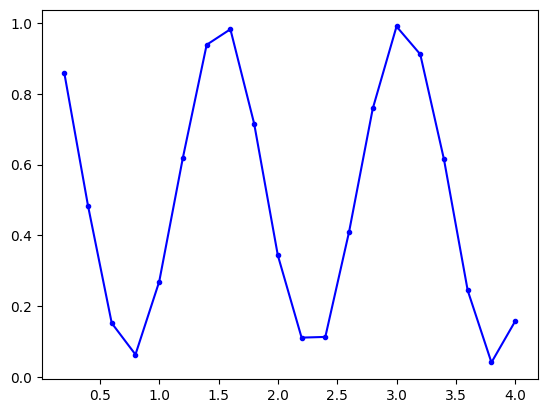

In [11]:
def ising_energy(counts, J, A):
    """
    Compute the energy of an Ising model configuration.
    
    Parameters:
    -----------
    bitstring : str
        A string of '0's and '1's representing spin configuration
    J : float
        Coupling constant
    A : array-like (2D)
        Adjacency matrix defining the graph structure
    
    Returns:
    --------
    float
        The energy of the configuration
    """
    # Convert bitstring to spin values: 0 -> -1, 1 -> +1
    energy = 0.0
    tot = 0
    for bitstring, value in counts.items():
        spins = [2*int(bit) - 1 for bit in bitstring]
        n = len(spins)
    
        # Compute energy: E = -J * sum_{i,j} A_{i,j} * s_i * s_j
        ez = 0
        for i in range(n):
            for j in range(i+1, n):  # Count each pair once
                ez += J * A[i][j] * spins[i] * spins[j]
        #print('DEBUG: ', bitstring, ez)
        energy += ez*value
        tot += value
    return energy/tot

def make_energy(test_counts,nq,tot_steps,A):
    ez = np.empty( tot_steps)
    for steps in range(tot_steps):
        counts = test_counts[steps]
        ez[steps] = ising_energy(counts,1,A)
    return  ez

# energy calculation and plot
sim_energy = make_energy(sim_counts,len(G),tot_steps,A)
plt.plot(np.arange(dt,dt*(tot_steps+1),dt),sim_energy,'.-', color='blue', label='Exact')

#### TASK 5: Estimate single-qubit magnetizations $\langle Z_i \rangle$

Compute the single-qubit magnetization along $z$:

$$
\langle Z_i \rangle = \langle \psi | Z_i | \psi \rangle.
$$

Since measurements are performed in the computational ($Z$) basis,  
$\langle Z_i \rangle$ can be obtained directly from the bitstring statistics.

For each outcome:

- bit `0` → eigenvalue $+1$
- bit `1` → eigenvalue $-1$

Therefore,

$$
\langle Z_i \rangle = \sum_s p(s)\, z_i(s),
$$

where $p(s)$ are the normalized probabilities and $z_i(s)=\pm1$ depending on the bit value at position $i$.


#### Your tasks:

1. Write a function that computes $\langle Z_i \rangle$ from a counts dictionary.
2. Using it, compute the average magnetization

$$
M_z(t) = \frac{1}{N_q} \sum_i \langle Z_i \rangle
$$

for each Trotter step.


<details>
<summary><b>Click to reveal solution</b></summary>

```python
backend_sim_exact = AerSimulator(method="automatic")
 
def z_expectation(counts, index):
    """
    counts: Dict of mitigated bitstrings.
    index: Index i in the single operator expectation value < II...Z_i...I > to be calculated.
    return:  < Z_i >
    """
    z_exp = 0
    tot = 0
    for bitstring, value in counts.items():
        bit = int(bitstring[index])
        sign = 1
        if bit % 2 == 1:
            sign = -1
        z_exp += sign * value
        tot += value
 
    return z_exp / tot

def make_magnetization(test_counts, nq, tot_steps):
    mz = np.empty((nq, tot_steps))
    for steps in range(tot_steps):
        counts = test_counts[steps]
        for i in range(nq):
            mz[i, steps] = z_expectation(counts, i)
    average_z = np.mean(mz, axis=0)
    return average_z


#check

sim_magnetization_z = make_magnetization(sim_counts[0:tot_steps], nq=len(G), tot_steps=tot_steps)
plt.plot(np.arange(dt,dt*(tot_steps+1),dt),sim_magnetization_z,'.-', color='blue', label='M_z')
plt.legend()

```
</details>

#### TASK 6

Measure the magnetization along $x$:

$$
M_x(t) = \frac{1}{N_q} \sum_i \langle X_i \rangle
$$

and compare it with $M_z(t)$.


**Bonus:**  
Keep the total time $t = \text{steps} \times dt$ fixed and vary the number of Trotter steps.  
Compare the results and comment on the Trotter error.

<details>
<summary><b>Click to reveal solution</b></summary>

```python

tot_steps = 20
n_qubits = 2
A = nn_adj_matrix(n_qubits)
G = nx.from_numpy_array(A)
J=1
h=2
dt=0.2
circ_2 = trotter_circuits(G, tot_steps, J, h, dt, "X", True)

sim_counts_x = run_sim(circ_2,backend_sim_exact)
print(sim_counts_x)
sim_magnetization_x = make_magnetization(sim_counts_x[0:tot_steps], nq=len(G), tot_steps=tot_steps)


plt.plot(np.arange(dt,dt*(tot_steps+1),dt),sim_magnetization_x,'.-', color='red', label='M_x')
plt.legend()

```

## Step 4: Noisy Simulations
In this section we extend the ideal quantum simulation to include realistic noise effects.
Quantum hardware is affected by different types of errors, which can significantly alter the dynamics of many-body systems such as the transverse-field Ising model.
To study the robustness of the dynamics, we introduce different noise models and compare their effects. 

#### Why Noisy Simulations?

In an ideal simulator (statevector), quantum evolution is perfectly unitary:
$$
\rho(t) = U(t)\,\rho(0)\,U^\dagger(t)
$$

However, real quantum devices suffer from: Gate errors, Decoherence (T1 and T2 processes), Crosstalk, Measurement errors.
To emulate realistic hardware behavior, we use Qiskit Aer NoiseModel and simulate the circuits with a finite number of shots.

#### Bit-flip noise
Models random $X$ errors occurring during gate operations or before measurement.
Channel: $$ \rho \rightarrow (1 - p)\rho + p X \rho X $$
This type of noise primarily affects populations in the computational basis.

#### Phase-flip noise
Models $Z$ errors that destroy quantum phase coherence.
Channel: $$ \rho \rightarrow (1 - p)\rho + p Z \rho Z$$

This mainly affects superposition states and coherence in the $X/Y$ basis.

<details>
<summary><b>Click to show example with only bit-flip or only phase-flip noise</b></summary>

```python

# BIT FLIP NOISE MODEL

from qiskit_aer.noise import NoiseModel, pauli_error

# Example error probabilities
p_meas = 0.02
p_gate1 = 0.01

#BIT FLIP
# QuantumError objects
error_meas_X = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1_X = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2_X = error_gate1_X.tensor(error_gate1_X)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_meas_X, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1_X, ["rx","rz","h"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2_X, ["cx"])


#PHASE FLIP
# QuantumError objects
error_meas_Z = pauli_error([('Z', p_meas), ('I', 1 - p_meas)])
error_gate1_Z = pauli_error([('Z', p_gate1), ('I', 1 - p_gate1)])
error_gate2_Z = error_gate1_Z.tensor(error_gate1_Z)

# Add errors to noise model
noise_phase_flip = NoiseModel()
noise_phase_flip.add_all_qubit_quantum_error(error_meas_Z, "measure")
noise_phase_flip.add_all_qubit_quantum_error(error_gate1_Z, ["rx","rz","h"])
noise_phase_flip.add_all_qubit_quantum_error(error_gate2_Z, ["cx"])

print(noise_bit_flip)
</details>
```

#### Depolarizing noise model
A more complete model includes all random Pauli errors and it is called *Depolarizing noise*. We can also combine it with *readout errors*.

The depolarizing channel is defined as: $$\rho \rightarrow (1 - p)\rho + \frac{p}{3}\left( X \rho X + Y \rho Y + Z \rho Z \right)$$

Readout errors are modeled classically through a conditional probability matrix:
$$P(|\psi_{\mathrm{meas}}\rangle ∣|\psi_{\mathrm{true}}\rangle)$$

This composite model better approximates physical quantum hardware.

In [14]:
#DEPOLARIZING NOISE + READOUT ERROR

from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

# Parameters
p1, p2 = 0.001, 0.01      # depolarizing 1q e 2q

# gates errors
err_1q = depolarizing_error(p1, 1)
err_2q = depolarizing_error(p2, 2)

# Readout error 
p01, p10 = 0.02, 0.03
readout = ReadoutError([[1-p01, p01],
                        [p10, 1-p10]])

composed_noise = NoiseModel()
composed_noise.add_all_qubit_quantum_error(err_1q, ["rx", "ry", "rz", "sx", "x","h"])
composed_noise.add_all_qubit_quantum_error(err_2q, ["cx"])
composed_noise.add_all_qubit_readout_error(readout)
print(composed_noise)


NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rx', 'ry', 'rz', 'sx', 'x']
  Instructions with noise: ['ry', 'h', 'x', 'cx', 'measure', 'sx', 'rz', 'rx']
  All-qubits errors: ['rx', 'ry', 'rz', 'sx', 'x', 'h', 'cx', 'measure']


<details>
<summary><b>Click to show example combining depolarizing noise with thermal relaxation and readout errors</b></summary>

```python

from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

# Parameters
p1, p2 = 0.001, 0.01      # depolarizing 1q e 2q
T1, T2 = 50e3, 70e3       # relaxation times in ns 
t1q, t2q = 50, 300        # gate durations in ns

# gates errors
err_1q = depolarizing_error(p1, 1).compose(thermal_relaxation_error(T1, T2, t1q))
err_2q = depolarizing_error(p2, 2).compose(
    thermal_relaxation_error(T1, T2, t2q).tensor(thermal_relaxation_error(T1, T2, t2q))
)

# Readout error 
p01, p10 = 0.02, 0.03
readout = ReadoutError([[1-p01, p01],
                        [p10, 1-p10]])

composed_noise = NoiseModel()
composed_noise.add_all_qubit_quantum_error(err_1q, ["rx", "ry", "rz", "sx", "x","h"])
composed_noise.add_all_qubit_quantum_error(err_2q, ["cx"])
composed_noise.add_all_qubit_readout_error(readout)
print(composed_noise)

</details>
```

#### Noise Model from Real Backend
In order to simulate realistic hardware behavior, we construct a noise model directly from a real quantum device configuration.
Instead of manually defining error channels (bit-flip, depolarizing, thermal relaxation, ...), we use the calibration data of a backend to automatically generate a consistent and hardware-aware noise model.

In [16]:
# SIMULATOR WITH NOISE MODEL FROM REAL BACKEND 

from qiskit_ibm_runtime.fake_provider import FakeRomeV2, FakeSantiagoV2, FakeLimaV2
from qiskit_aer.noise import NoiseModel

backend = FakeRomeV2()   # choose another Fake*V2
noise_model_from_backed = NoiseModel.from_backend(backend)


#### TASK 6: Noisy Simulation and Comparison with the Noiseless Case

After defining the noise model, perform the following steps:

1. Run the circuit using an `AerSimulator` configured with the previously defined noise model.
2. Collect the measurement counts from the noisy simulation, by applying the same normalization procedure used in the noiseless case (from **TASK 4**).
3. Compute:
   - Energy 
   - Magnetization (from **TASK 5**)
   
4. Plot and compare the noisy and noiseless results for both magnetization and energy.

<details>
<summary><b>Click to reveal solution</b></summary>

```python
from qiskit_aer import AerSimulator


tot_steps = 20
n_qubits = 8
A = nn_adj_matrix(n_qubits)
G = nx.from_numpy_array(A)
J=1
h=2
dt=0.2
qc = trotter_circuits(G, tot_steps, J, h, dt, "X", True)

backend_sim_exact = AerSimulator(method="automatic")
#noise_model = noise_model_from_backed
noise_model = composed_noise
backend_sim_noisy = AerSimulator(noise_model=noise_model)
sim_counts_noisy = run_sim(qc,backend_sim_noisy)
sim_counts = run_sim(qc,backend_sim_exact)

sim_exp = make_magnetization(sim_counts[0:tot_steps], nq=len(G), tot_steps=tot_steps)
sim_exp_noisy = make_magnetization(sim_counts_noisy[0:tot_steps], nq=len(G), tot_steps=tot_steps)

sim_energy = make_energy(sim_counts,len(G),tot_steps,A)
sim_energy_noisy = make_energy(sim_counts_noisy,len(G),tot_steps,A)

plt.figure()
plt.plot(sim_exp,'.-', color='blue', label='Exact')
plt.plot(sim_exp_noisy,'.-', color='orange', label='Noisy')
plt.title(r'$M_z$')
plt.legend()

plt.figure()
plt.title(r'$\langle H_z \rangle$')
plt.plot(sim_energy,'.-', color='blue', label='Exact')
plt.plot(sim_energy_noisy,'.-', color='orange', label='Noisy')
plt.legend()
```
</details>

## STEP 5: Quantum Annealing (Second-Order Trotterization)

In this step we move from real-time Trotterized dynamics to a **digital quantum annealing** protocol.  
Instead of simulating the evolution under a fixed Hamiltonian

$$
U(t)=e^{-iHt},
$$

we consider a **time-dependent Hamiltonian**

$$
H(s)=A(s)\,H_D + B(s)\,H_C, 
\qquad 
s=\frac{t}{T}\in[0,1].
$$


#### Hamiltonian Definition

For the Ising model defined on a 1D (or generic) interaction graph we introduce:

**Driver Hamiltonian**
$$
H_D=-h\sum_i X_i,
$$

**Problem Hamiltonian**
$$
H_C=J\sum_{\langle i,j\rangle} Z_iZ_j.
$$

The full annealing Hamiltonian is therefore

$$
H(s)=-A(s)\,h\sum_i X_i + B(s)\,J\sum_{\langle i,j\rangle} Z_iZ_j.
$$

We use a simple linear schedule

$$
A(s)=1-s, 
\qquad 
B(s)=s.
$$

At $s=0$ the system is governed entirely by the driver Hamiltonian, while at $s=1$ it is governed by the problem Hamiltonian.


#### Digital Implementation

The system is initialized in the ground state of $H_D$, namely

$$
|+\rangle^{\otimes n}.
$$

We discretize the total annealing time $T$ into $N$ steps of duration

$$
\Delta t=\frac{T}{N}.
$$

At each step $k=1,\dots,N$ we evaluate the schedule at the midpoint

$$
s_k=\frac{k-\tfrac12}{N},
$$

and define

$$
H_k = A(s_k)\,H_D + B(s_k)\,H_C.
$$

Using a **second-order Trotter decomposition**, the short-time propagator is approximated as

$$
e^{-iH_k\Delta t}
\;\approx\;
e^{-i\,A(s_k)\,H_D\,\Delta t/2}
\;
e^{-i\,B(s_k)\,H_C\,\Delta t}
\;
e^{-i\,A(s_k)\,H_D\,\Delta t/2}.
$$

The full annealing evolution is therefore

$$
U(T)\approx \prod_{k=1}^{N}
\left[
e^{-i\,A(s_k)\,H_D\,\Delta t/2}
\;
e^{-i\,B(s_k)\,H_C\,\Delta t}
\;
e^{-i\,A(s_k)\,H_D\,\Delta t/2}
\right].
$$





### TASK 7:Build Digital Quantum Annealing Circuits   

This second-order structure matches exactly the **driver–problem–driver** pattern used in the TFIM Trotter step from Task 2.

The only difference is that the angles are **step-dependent**, because $A(s_k)$ and $B(s_k)$ vary with $k$.

- The $H_D$ terms are implemented through layers of **RX rotations**.
- The $H_C$ terms are implemented with **RZZ gates** (or CNOT–RZ–CNOT decompositions) along the edges of the interaction graph.

At step $k$ the rotation angles become:

- Driver half-step:
$$
\theta_x(k) \propto A(s_k)\,\frac{\Delta t}{2}
$$

- Problem step:
$$
\theta_{zz}(k) \propto B(s_k)\,\Delta t
$$

Therefore, we can reuse exactly the same single-step construction defined in Task 2 (e.g., `generate_tfim_single_trotter_step`), while simply updating the angles at each annealing step according to the schedule.

This allows us to study digital quantum annealing within the same gate-based framework used for real-time Trotterized evolution, but now with a time-dependent Hamiltonian.

**Remind also to build a list of circuits for dynamical evolution**

Generate a **list of quantum circuits** with increasing depth, corresponding to different total simulation times. By sweeping over the number of Trotter steps, we obtain circuits representing the system at different times during the annealing sweep.



<details>
<summary><b>Click to reveal solution</b></summary>

```python
import numpy as np
import networkx as nx
from qiskit.circuit import QuantumCircuit

# We assume these are already defined from Task 2:
# - generate_tfim_single_trotter_step(nq, theta_x, theta_zz, pairs_set, mirror=False)
# - pair_selection_1d(nq)  (or another function that builds pairs_set from the graph)
# - my_rzz(circ, edge, theta_zz)

def generate_quantum_annealing_circ_custom_graph(
    steps: int,
    h: float,
    J: float,
    T: float,
    graph: nx.Graph,
    meas_basis: str = "Z",
    mirror: bool = False,
    add_barriers: bool = True,
):
    """
    Build ONE digital quantum annealing circuit using second-order (Strang) Trotterization,
    reusing exactly generate_tfim_single_trotter_step, but with step-dependent angles
    according to the annealing schedule A(s)=1-s, B(s)=s.

    steps: number of annealing (Trotter) steps N
    h: transverse field strength in H_D = -h Σ X
    J: coupling in H_C = J Σ ZZ
    T: total annealing time
    graph: nx.Graph encoding the ZZ couplings
    meas_basis: "X", "Y", or "Z"
    mirror: if True, alternate edge ordering in the single-step blocks
    add_barriers: add barriers between blocks
    """
    nq = graph.number_of_nodes()
    dt = T / steps

    # In Task 2 you use a "pairs_set" structure (list of edge-lists) to avoid conflicts.
    # Keep the same tool to construct it (here we reuse pair_selection_1d for 1D layouts).
    # If you already have a graph-based pairing function, use that instead.
    pairs_set = pair_selection_1d(nq)

    circ = QuantumCircuit(nq, nq)

    # Initial state |+>^n (ground state of the driver Hamiltonian)
    circ.h(range(nq))

    # Concatenate annealing Trotter steps with step-dependent parameters
    for k in range(steps):
        s = (k + 0.5) / steps
        A = 1.0 - s
        B = s

        # Match the conventions of generate_tfim_single_trotter_step:
        #   theta_x  = 0.5 * h * dt
        #   theta_zz = - J * dt
        #
        # Insert annealing schedule:
        theta_x = 0.5 * (A * h) * dt
        theta_zz = -(B * J) * dt

        trotter_step = generate_tfim_single_trotter_step(
            nq, theta_x, theta_zz, pairs_set, mirror=(mirror and (k % 2 == 1))
        )
        circ.compose(trotter_step, inplace=True)

        if add_barriers:
            circ.barrier()

    # Basis rotations before measurement
    if meas_basis == "X":
        for b in range(nq):
            circ.h(b)
    elif meas_basis == "Y":
        for b in range(nq):
            circ.sdg(b)  # phase gate with phi = -pi/2
            circ.h(b)

    # Measurements
    circ.measure(range(nq), range(nq))
    return circ


def annealing_trotter_circuits(
    G: nx.Graph,
    tot_steps: int,
    J: float,
    h: float,
    T: float,
    meas_basis: str = "Z",
    mirror: bool = True,
    add_barriers: bool = True,
):
    """
    Generates a list of annealing circuits with increasing depth (1..tot_steps),
    so you can pass them directly to run_sim.

    G: Graph defining spin interactions (edges = ZZ couplings)
    tot_steps: maximum number of annealing (Trotter) steps
    J: ZZ coupling in H_C
    h: transverse field in H_D
    T: total annealing time
    meas_basis: "X", "Y", or "Z"
    mirror: if True, alternate edge ordering between layers
    add_barriers: add barriers between layers
    """
    circuits = []
    for steps in range(1, tot_steps + 1):
        circuits.append(
            generate_quantum_annealing_circ_custom_graph(
                steps=steps,
                h=h,
                J=J,
                T=T,
                graph=G,
                meas_basis=meas_basis,
                mirror=mirror,
                add_barriers=add_barriers,
            )
        )
    return circuits



n_steps = 80
n_qubits = 8
A = nn_adj_matrix(n_qubits)
G = nx.from_numpy_array(A)
J=1
h=2
dt=0.2
qc = annealing_trotter_circuits(G, tot_steps= n_steps, J=J, h=h, T=5, meas_basis= "Z")

```

</details>

#### TASK 8: Noiseless and Noisy Quantum Annealing and estimation of quantities of interest

Perform the quantum annealing  

1. Run the circuit using an `AerSimulator` configured with the previously defined noise model and also without noise.
2. Collect the measurement counts from the noisy simulation, by applying the same normalization procedure used in the noiseless case (from **TASK 4**).
3. Compute:
   - Energy 
   - Magnetization (from **TASK 5**)
   
4. Plot and compare the noisy and noiseless results for both magnetization and energy.

**BONUS**: study the final energy as a function of the total evolution time. What do you observe?

<details>
<summary><b>Click to reveal solution</b></summary>

```python
from qiskit_aer import AerSimulator

# measuring all the circuits 


n_steps = 20
n_qubits = 4
A = nn_adj_matrix(n_qubits)
G = nx.from_numpy_array(A)
J=1
h=2
dt=0.2
QA_qc = annealing_trotter_circuits(G, tot_steps= n_steps, J=J, h=h, T=1, meas_basis= "Z")


ideal_backend = AerSimulator(method="automatic")
noise_model = noise_model_from_backed

backend_sim_noisy = AerSimulator(noise_model=noise_model)

ideal_counts_list = run_sim(QA_qc,backend_sim_exact)
noisy_counts_list = run_sim(QA_qc,backend_sim_noisy)

ideal_energy_steps = [ising_energy(c, J, A) for c in ideal_counts_list]
noisy_energy_steps = [ising_energy(c, J, A) for c in noisy_counts_list]

print("E(0) ideal:", ideal_energy_steps[0], "   E(final) ideal:", ideal_energy_steps[-1])
print("E(0) noisy:", noisy_energy_steps[0], "   E(final) noisy:", noisy_energy_steps[-1])

import matplotlib.pyplot as plt

steps = np.arange(1, n_steps + 1)

plt.figure()
plt.plot(steps, ideal_energy_steps, label="ideal")
plt.plot(steps, noisy_energy_steps, label="noisy")
plt.xlabel("Annealing step")
plt.ylabel("Energy")
plt.legend()
plt.show()

annealing_exp = make_magnetization(ideal_counts_list[0:n_steps], nq=len(G), tot_steps=n_steps)
annealing_exp_noisy = make_magnetization(noisy_counts_list[0:n_steps], nq=len(G), tot_steps=n_steps)

annealing_energy = make_energy(ideal_counts_list,len(G),n_steps,A)
annealing_energy_noisy = make_energy(noisy_counts_list,len(G),n_steps,A)

plt.figure()
plt.plot(annealing_exp,'.-', color='blue', label='Exact')
plt.plot(annealing_exp_noisy,'.-', color='orange', label='Noisy')
plt.legend()

plt.figure()
plt.plot(annealing_energy,'.-', color='blue', label='Exact')
plt.plot(annealing_energy_noisy,'.-', color='orange', label='Noisy')
plt.legend()
```
</details>